In [1]:
from sklearn.decomposition import PCA
from model.TransE import *
from model.ConvKB import ConvKB
from model.utils import *
from model.CustomTripletMarginLoss import CustomTripletMarginLoss
from argparse import Namespace
import torch
import torch.nn as nn
import sys
from torch.autograd import Variable
import torch.optim as optim
from numpy import linalg as LA
import numpy as np
from math import log10,floor
import json
import pickle,os
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

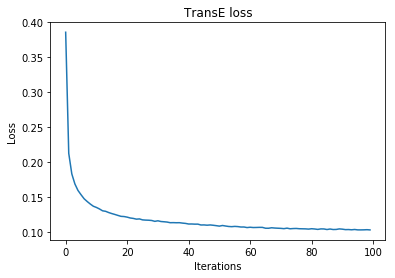

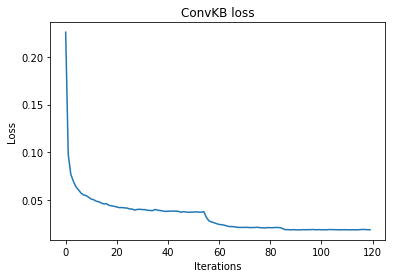

In [2]:
#visualize loss function
trans_e_loss =[]
with open("./data/GENE/loss_transe.txt","r") as f:
    for loss in f.readlines():
        trans_e_loss.append(float(loss[0:len(loss)-1]))
    f.close()
conv_kb_loss =[]
with open("./data/GENE/loss_convkb.txt","r") as f:
    for loss in f.readlines():
        conv_kb_loss.append(float(loss[0:len(loss)-1]))
    f.close()
    
plt.plot(range(len(trans_e_loss)),trans_e_loss)
plt.title('TransE loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(range(len(conv_kb_loss)),conv_kb_loss)
plt.title('ConvKB loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [3]:
NUMBER_NEIGHBORS = 15

In [4]:

if torch.cuda.is_available():
    net = torch.load("./data/GENE/ConvKB.pkl")
else:
    net = torch.load("./data/GENE/ConvKB.pkl", map_location=lambda storage, loc: storage)
net = list(net.items())
# 1: entity
# 2: relation
data_train = net[0][1].cpu().numpy()

if os.path.exists("./data/GENE/kNN.pkl"):
    with open("./data/GENE/kNN.pkl", "rb") as f:
        nbrs = pickle.load(f)
        f.close()
    with open("./data/GENE/indices.pkl", "rb") as f:
        indices = pickle.load(f)
        f.close()
    with open("./data/GENE/distance.pkl", "rb") as f:
        distances = pickle.load(f)
        f.close()
else:
    nbrs = NearestNeighbors(n_neighbors=NUMBER_NEIGHBORS, algorithm='ball_tree').fit(data_train)
    distances, indices = nbrs.kneighbors(data_train)
    with open("./data/GENE/kNN.pkl", "wb") as f:
        pickle.dump(nbrs,f)
        f.close()
    with open("./data/GENE/indices.pkl", "wb") as f:
        pickle.dump(indices, f)
        f.close()
    with open("./data/GENE/distance.pkl", "wb") as f:
        pickle.dump(distances, f)
        f.close()

In [5]:
#Load data to show attributes of gene
with open("./support/uniprot.pkl","rb") as f:
    uniprot = pickle.load(f)
    f.close()
with open("./support/prin.pkl","rb") as f:
    prin = pickle.load(f)
    f.close()
with open("./support/pyrice.pkl","rb") as f:
    pyrice = pickle.load(f)
    f.close()
with open("./support/id_dict_2018", "rb") as f:
    id_dict_2018 = pickle.load(f)
    f.close()
with open("./support/loc_dict_2018", "rb") as f:
    loc_dict_2018 = pickle.load(f)
    f.close()
processed_entity_2_id = load_data("./data/GENE/entity2id.txt", ignore_first=True)
relation_2_id = load_data("./data/GENE/relation2id.txt", ignore_first=True)
processed_id_2_entity = dict()
i = 0
with open("./data/GENE/entity2id.txt", 'r') as f:
    for line in f:
        if True and i == 0:
            i += 1
            continue
        line = line.strip()
        if line == '':
            continue
        parts = line.split("\t")
        processed_id_2_entity[int(parts[1])] = parts[0]

In [9]:
candidate = []
for att in processed_entity_2_id.keys():
    if att not in id_dict_2018.keys():
        candidate.append(att)

In [12]:
#RUN WITH ALL GENE
get_index_gene = []
for gene_name in id_dict_2018.keys():
    if gene_name in processed_entity_2_id.keys():
        get_index_gene.append(processed_entity_2_id[gene_name])  

In [14]:
len(candidate) + len(get_index_gene)

33267

In [15]:
len(processed_entity_2_id)

33267

In [41]:
from scipy.stats import rankdata
import math
rankdata([0.5, 2.4, 3.2, 2.5], method='ordinal')

array([1, 2, 4, 3])

In [19]:
batch_size = 5
a = [0.5, 2.4, 3.2, 2.5, 0.5, 2.4, 3.2, 2.5, 0.5, 2.4, 3.2, 2.5]
mix_ids = np.random.permutation(len(a))
n_batches = int (np.ceil(len(a)/float(batch_size)))
for ib in range(n_batches):
    rand_index = mix_ids[batch_size*ib:min(batch_size*(ib+1),len(a))]
    print(rand_index)
#     rand_x = x_train[rand_index]
#     rand_y = y_train[rand_index,:]

[ 0 11  3  8  7]
[5 2 9 4 1]
[10  6]


In [62]:
#a = [1.410244107246399, 0.9492931962013245, 0.8127169609069824, 1.0522962808609009, 0.834714412689209, 0.4240999221801758, 0.2974086403846741, 0.7997349500656128, 0.7182353138923645, 0.570691704750061, 1.1118582487106323, 0.838465690612793, 0.6364452838897705, 0.876560389995575, 0.5968449115753174, 0.9492029547691345, 0.6066585779190063, 0.45165586471557617, 0.7758960127830505, 0.44500666856765747, 0.7219889163970947, 0.849268913269043, 0.2884458899497986, 1.100389003753662, 1.042898178100586, 0.8358440399169922, 0.5032087564468384, 0.6828633546829224, 1.0646111965179443, 0.9964385032653809, 0.9975290298461914, 0.6400842666625977, 0.8497111797332764, 0.8683788776397705, 0.5488479137420654, 0.5932359099388123, 0.4015885591506958, 0.5962696075439453, 0.39365649223327637, 0.6310158967971802, 0.6262844800949097, 0.09642773866653442, 0.4245191812515259, 0.5119014978408813, 0.2904796600341797, 0.2816142439842224, 0.9073539972305298, 0.7055412530899048, 0.766243040561676, 0.892164945602417, 0.5394891500473022, 0.26617372035980225, 0.24310290813446045, 0.7396718263626099, 0.5286761522293091, 1.157266616821289, 0.5878900289535522, 0.6296825408935547, 0.2579648494720459, 0.37306612730026245, 0.5815361738204956, 0.5228581428527832, 0.5361466407775879, 1.1299420595169067, 0.8627766370773315, 0.7703155279159546, 0.7790067791938782, 0.4858096241950989, 0.3769040107727051, 0.5993412733078003, 0.6684583425521851, 0.896981418132782, 0.30057209730148315, 0.9763562679290771, 0.7485538125038147, 0.5432226657867432, 0.0, 0.19498389959335327, 0.6558998823165894, 0.8268486261367798, 0.44506508111953735, 0.5739213228225708, 0.5660468339920044, 0.9703713059425354, 0.8824158310890198, 1.410244107246399, 1.102952480316162, 0.7171846628189087, 0.5658403038978577, 1.8001246452331543, 0.2995004653930664, 0.6246556043624878, 1.1108794212341309, 0.5164605379104614, 0.5631529688835144, 0.5423110127449036, 0.5212674140930176, 0.6783964037895203, 0.6702402830123901, 0.335635781288147, 0.9321143627166748, 0.5845244526863098, 0.5611586570739746, 0.7893513441085815, 0.9477338790893555, 0.4920473098754883, 0.9404323697090149, 1.0172597169876099, 0.31081533432006836, 0.7336050868034363, 0.916678249835968, 0.5601086616516113, 0.5375173091888428, 0.8247566819190979, 0.73769211769104, 0.4537525773048401, 0.32265979051589966, 0.8514284491539001, 0.3899840712547302, 0.5984205007553101, 0.39920347929000854, 0.7036766409873962, 0.5451509356498718, 0.9023647904396057, 0.8080775141716003, 0.6646469831466675, 0.8014994263648987, 0.7539701461791992, 0.5252426862716675, 0.7193995714187622, 0.3987494111061096, 0.9946882724761963, 1.7133665084838867, 1.1146705150604248, 1.0484824180603027, 0.5038068890571594, 0.5144575238227844, 0.5396518707275391, 0.26833873987197876, 0.7295526266098022, 0.3749738335609436, 0.32690924406051636, 1.1265493631362915, 0.2803801894187927, 0.7946397066116333, 0.592877209186554, 0.5150484442710876, 0.7482836842536926, 1.139051079750061, 1.0047098398208618, 0.40885937213897705, 0.4187543988227844, 0.5990120768547058, 0.5128011703491211, 0.9946461915969849, 0.2531753182411194, 0.8277051448822021, 0.24693018198013306, 0.9928208589553833, 0.6560127139091492, 0.7365249991416931, 1.0928101539611816, 1.195551872253418, 0.1476966142654419, 1.115207314491272, 0.6963902711868286, 0.8895084857940674, 0.3344234824180603, 0.5960278511047363, 0.6392371654510498, 0.8468132019042969, 0.7677377462387085, 0.90248042345047, 0.648261308670044, 0.5926072597503662, 0.482455849647522, 0.9262130260467529, 0.782042920589447, 0.7278338074684143, 1.143288254737854, 0.7833231687545776, 0.6709339022636414, 0.6739131212234497, 0.8921006917953491, 0.5304291844367981, 0.8589998483657837, 0.4077826738357544, 0.48924410343170166, 0.6232138276100159, 0.5463950634002686, 0.5736254453659058, 0.7017180323600769, 1.0470834970474243, 0.21270906925201416, 0.8268289566040039, 0.5858991146087646, 0.7106372117996216, 0.4410249590873718, 0.37599295377731323, 1.1538488864898682, 0.7605239748954773, 0.7890010476112366, 0.7282018661499023, 1.0676292181015015, 0.3915415406227112, 0.577702522277832, 0.624381422996521, 0.5238467454910278, 0.5809558629989624, 0.6495046615600586, 0.6465364098548889, 0.8236087560653687, 0.7027171850204468, 0.5851144790649414, 0.5981470346450806, 0.48325783014297485, 0.7431251406669617, 0.6470098495483398, 0.5283074378967285, 0.8172653913497925, 0.8801887631416321, 0.8455365896224976, 0.4160205125808716, 0.13892102241516113, 0.4607033133506775, 0.7012845277786255, 0.6648151874542236, 0.2610807418823242, 1.023069977760315, 0.8405494093894958, 0.3255586624145508, 0.42334502935409546, 0.7198511362075806, 0.6773141622543335, 1.2157374620437622, 0.990069568157196, 0.8177478313446045, 0.547850489616394, 0.9679936170578003, 0.8178274035453796, 0.618690013885498, 0.5603440999984741, 0.6111968755722046, 0.7169731855392456, 1.0488946437835693, 0.6380079984664917, 1.0891849994659424, 0.4684339165687561, 0.642048716545105, 0.5458909273147583, 0.5959568023681641, 0.7625805139541626, 0.6044712066650391, 0.4059757590293884]
#a =[1.2834597826004028, 0.49395042657852173, 0.6895184516906738, 0.912142276763916, 0.6937410235404968, 0.7456322908401489, 0.05175423622131348, 0.7337169647216797, 1.0899666547775269, 0.7744183540344238, 0.956645667552948, 0.4702710509300232, 0.4356216788291931, 0.4157741665840149, 0.6376722455024719, 0.5863382816314697, 0.40179479122161865, 0.38956862688064575, 0.5430399775505066, 0.4595576524734497, 0.4961586594581604, 1.0456209182739258, 0.0980224609375, 0.6493645906448364, 0.31840044260025024, 0.5047395825386047, 0.5927826166152954, 0.6973342895507812, 0.9477517008781433, 1.1191800832748413, 0.7920445799827576, 0.4332663416862488, 0.6853295564651489, 0.5821921825408936, 0.6399773359298706, 0.5626038908958435, 0.5775889158248901, 0.46119236946105957, 0.5019204616546631, 0.6462169885635376, 0.553981363773346, 0.28495335578918457, 0.4559812545776367, 0.7593693733215332, 0.004096388816833496, 0.16776829957962036, 0.8433554768562317, 0.8815979957580566, 0.8825097680091858, 0.6091825366020203, 0.43917620182037354, 0.7640755772590637, 0.12943178415298462, 0.5737941265106201, 0.44042056798934937, 0.6900285482406616, 0.48483580350875854, 0.7873802781105042, 0.47978508472442627, 0.40036702156066895, 0.5034561157226562, 0.6125432848930359, 0.6637136340141296, 1.0967578887939453, 0.9711687564849854, 0.48101741075515747, 0.7464119791984558, 0.5256258249282837, 0.1764698028564453, 0.748762845993042, 0.49925291538238525, 1.2662360668182373, 0.36495548486709595, 0.5612590909004211, 0.5875624418258667, 0.45239800214767456, 0.12672209739685059, 0.4785410165786743, 0.7090263366699219, 0.5554990172386169, 0.5297936201095581, 0.5143362283706665, 0.39564722776412964, 0.810314416885376, 0.42434781789779663, 0.8833520412445068, 1.0806608200073242, 0.5867676138877869, 0.6374728679656982, 0.8737877011299133, 0.38182371854782104, 0.56524258852005, 0.976268470287323, 0.6309176683425903, 0.7862740755081177, 0.7867480516433716, 0.4720095992088318, 1.160679578781128, 0.38327258825302124, 0.4011423587799072, 0.777946949005127, 0.6027132272720337, 0.6742532253265381, 0.5051387548446655, 0.7500704526901245, 0.6255591511726379, 0.4761730432510376, 0.7013161182403564, 0.40888017416000366, 1.2834597826004028, 0.9581987261772156, 0.706034779548645, 0.5213111639022827, 1.2629135847091675, 0.5542162656784058, 0.4132300615310669, 0.23520797491073608, 0.7007010579109192, 0.5032705068588257, 0.9130489230155945, 0.43146663904190063, 1.747492790222168, 0.49849504232406616, 0.5355601906776428, 1.0656458139419556, 0.30872470140457153, 0.7453674077987671, 0.8838106989860535, 0.3500368595123291, 0.7648866772651672, 0.5602397918701172, 0.8918898701667786, 0.9738514423370361, 0.9649339318275452, 1.243767499923706, 0.763866126537323, 0.657961368560791, 0.6763176918029785, 0.6702356338500977, 1.13135826587677, 0.5764714479446411, 0.38201379776000977, 0.8377725481987, 0.2776927351951599, 0.5705852508544922, 0.842350959777832, 0.2842724919319153, 0.8578071594238281, 0.8181061744689941, 0.8690313696861267, 0.10788488388061523, 0.15932810306549072, 0.5899304151535034, 0.7127975225448608, 0.9110591411590576, 0.3117886781692505, 0.749226450920105, 0.49001753330230713, 0.507347047328949, 0.45717352628707886, 0.7041788101196289, 0.8367727994918823, 0.9886230826377869, 0.0, 0.967232882976532, 0.4285740852355957, 0.5652241706848145, 0.41869407892227173, 0.748375415802002, 0.4559531807899475, 0.27531176805496216, 0.5946649312973022, 0.7408384084701538, 0.42154067754745483, 0.7360043525695801, 0.8003417253494263, 0.6376999616622925, 0.6079524755477905, 0.9156455993652344, 0.9871776103973389, 0.1640365719795227, 0.38842231035232544, 1.0875768661499023, 0.8460354804992676, 0.5792381167411804, 1.0139644145965576, 0.9650974869728088, 0.811273455619812, 0.6660731434822083, 0.25921040773391724, 0.7914496660232544, 0.876889705657959, 0.736115038394928, 0.3299487829208374, 0.8686174154281616, 0.45398038625717163, 0.3294641971588135, 0.16944867372512817, 0.5050783157348633, 0.8843576312065125, 0.6222322583198547, 0.5815049409866333, 0.5838252902030945, 1.371147871017456, 0.5813877582550049, 0.9675381183624268, 0.48338645696640015, 0.19384223222732544, 1.425656795501709, 0.3721153736114502, 0.3152235746383667, 1.2551188468933105, 0.619796633720398, 0.4287043809890747, 0.7293848991394043, 0.12538713216781616, 0.738503098487854, 0.7281266450881958, 0.9243583679199219, 1.0874817371368408, 0.8827410936355591, 0.8036754727363586, 0.5528354048728943, 0.4260738492012024, 0.5271875858306885, 0.5141501426696777, 0.8270556926727295, 0.3049160838127136, 0.6753339171409607, 0.4438629150390625, 0.41107743978500366, 0.7309271097183228, 1.1087968349456787, 0.7973331809043884, 0.892716646194458, 0.7411020398139954, 1.1770620346069336, 0.7385871410369873, 0.5262748003005981, 0.7200911045074463, 0.3935788869857788, 0.2675060033798218, 0.6363592743873596, 0.3301040530204773, 0.5828628540039062, 1.1393938064575195, 0.956198513507843, 0.5840559005737305, 0.4393923282623291, 0.5372408032417297, 0.8332622647285461, 1.1955020427703857, 0.4955543279647827, 0.3303438425064087]
a =[[-7.40765905380249], [26.639684677124023], [23.770580291748047], [25.21295738220215], [4.473738670349121], [10.957871437072754], [4.001723289489746], [11.545526504516602], [11.72877311706543], [17.385494232177734], [24.582536697387695], [3.980388879776001], [30.48578643798828], [8.483434677124023], [10.233524322509766], [8.7272367477417], [6.932642459869385], [10.082534790039062], [9.278692245483398], [9.878155708312988], [7.220635414123535], [21.125028610229492], [34.340885162353516], [10.310640335083008], [18.520524978637695], [18.1352596282959], [10.68270492553711], [23.61200523376465], [15.54517936706543], [2.3277995586395264], [17.52755355834961], [13.98405933380127], [16.935388565063477], [31.785818099975586], [5.755496978759766], [8.350666999816895], [10.267622947692871], [24.584585189819336], [3.727651357650757], [16.192157745361328], [13.8785400390625], [27.773883819580078], [27.028446197509766], [21.32977294921875], [8.539787292480469], [-0.33126387000083923], [7.827861785888672], [3.339888095855713], [3.013578414916992], [2.3518850803375244], [18.615835189819336], [7.1949310302734375], [8.85326099395752], [7.708542823791504], [13.028383255004883], [24.567529678344727], [9.026220321655273], [9.796651840209961], [7.590333938598633], [8.96153736114502], [17.797666549682617], [29.6938533782959], [14.927619934082031], [7.938042640686035], [28.511777877807617], [4.643346309661865], [10.534177780151367], [8.637771606445312], [9.741678237915039], [12.043466567993164], [19.303281784057617], [18.121164321899414], [14.666736602783203], [3.852041006088257], [4.924312114715576], [26.651752471923828], [16.377347946166992], [12.167309761047363], [12.450984954833984], [9.420448303222656], [10.790563583374023], [9.109201431274414], [18.0871639251709], [29.541431427001953], [23.023780822753906], [9.93692684173584], [6.000123023986816], [17.737384796142578], [23.127927780151367], [4.02288818359375], [-0.9229586720466614], [0.08490976691246033], [10.490538597106934], [18.728628158569336], [12.573318481445312], [4.625275135040283], [18.06328582763672], [9.213064193725586], [8.048912048339844], [2.031923532485962], [13.079133987426758], [16.686426162719727], [10.708693504333496], [16.5957088470459], [14.203171730041504], [7.8470072746276855], [23.969207763671875], [24.13456916809082], [-1.1476564407348633], [3.530233383178711], [5.5707106590271], [17.494516372680664], [5.941508769989014], [17.39000129699707], [9.459756851196289], [18.64937400817871], [7.178977012634277], [-7.40765905380249], [-6.922873020172119], [18.970478057861328], [17.45903205871582], [29.071073532104492], [9.85305404663086], [10.20522689819336], [12.831052780151367], [19.038177490234375], [17.665163040161133], [5.793592929840088], [7.458345413208008], [19.310081481933594], [33.74693298339844], [8.397214889526367], [7.1139140129089355], [10.590575218200684], [22.722675323486328], [10.912643432617188], [8.384294509887695], [12.320520401000977], [-5.969399452209473], [6.812117099761963], [8.06218433380127], [7.548025608062744], [14.937894821166992], [20.585538864135742], [31.91382598876953], [30.211233139038086], [22.88389778137207], [17.299318313598633], [8.49225902557373], [32.297698974609375], [14.705766677856445], [29.18610191345215], [34.5611457824707], [8.07568645477295], [7.187803268432617], [10.351156234741211], [9.719317436218262], [26.815664291381836], [24.006175994873047], [6.985091209411621], [7.363420009613037], [6.740007400512695], [18.22614097595215], [11.05322265625], [16.258798599243164], [17.080692291259766], [27.64253044128418], [14.792194366455078], [14.065256118774414], [22.829065322875977], [20.096424102783203], [14.546736717224121], [13.796890258789062], [24.567129135131836], [14.218713760375977], [10.191853523254395], [10.46248722076416], [5.715240955352783], [19.983064651489258], [7.438371658325195], [18.741453170776367], [19.861278533935547], [13.840139389038086], [18.551097869873047], [23.71974754333496], [9.670127868652344], [22.180606842041016], [22.507719039916992], [10.903030395507812], [1.279740333557129], [10.783730506896973], [6.82548713684082], [33.67317581176758], [18.294633865356445], [12.98216438293457], [20.95851707458496], [28.538097381591797], [11.44993782043457], [13.69466495513916], [24.59479522705078], [16.165273666381836], [9.566614151000977], [9.124768257141113], [9.14004898071289], [25.25750160217285], [26.84767723083496], [7.811948776245117], [23.185312271118164], [10.929070472717285], [22.90027618408203], [24.57904052734375], [27.052629470825195], [21.17367935180664], [32.64254379272461], [17.19022560119629], [13.369239807128906], [12.793580055236816], [17.87209701538086], [24.653886795043945]]
#a = np.asarray(a)
#b = 1-a/(max(a))
#b = 1/(1 + np.exp(-a))
b = torch.sigmoid(a)

TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not list

In [55]:
rankdata(a,method='ordinal')

array([  1, 196, 183, 194,  21,  98,  19, 101, 102, 139, 190,  18, 211,
        57,  83,  61,  34,  80,  69,  78,  40, 169, 218,  85, 154, 151,
        91, 181, 128,  11, 143, 118, 135, 212,  27,  54,  84, 191,  16,
       130, 117, 203, 200, 171,  59,   7,  48,  14,  13,  12, 156,  39,
        62,  46, 111, 188,  64,  76,  45,  63, 146, 209, 126,  50, 204,
        23,  89,  60,  75, 103, 162, 150, 123,  17,  24, 197, 132, 104,
       106,  70,  94,  65, 149, 208, 178,  79,  30, 145, 179,  20,   6,
         8,  88, 158, 107,  22, 148,  68,  51,  10, 112, 134,  92, 133,
       120,  49, 184, 186,   5,  15,  25, 142,  29, 140,  71, 157,  37,
         2,   3, 160, 141, 206,  77,  82, 109, 161, 144,  28,  43, 163,
       217,  56,  36,  90, 174,  96,  55, 105,   4,  32,  52,  44, 127,
       167, 213, 210, 176, 138,  58, 214, 124, 207, 219,  53,  38,  86,
        74, 198, 185,  35,  41,  31, 152,  99, 131, 136, 202, 125, 119,
       175, 166, 122, 115, 187, 121,  81,  87,  26, 165,  42, 15

In [56]:
rankdata(b,method='ordinal')

array([  1, 196, 183, 194,  21,  98,  19, 101, 102, 139, 190,  18, 211,
        57,  83,  61,  34,  80,  69,  78,  40, 169, 218,  85, 154, 151,
        91, 181, 128,  11, 143, 118, 135, 212,  27,  54,  84, 191,  16,
       130, 117, 203, 200, 171,  59,   7,  48,  14,  13,  12, 156,  39,
        62,  46, 111, 188,  64,  76,  45,  63, 146, 209, 126,  50, 204,
        23,  89,  60,  75, 103, 162, 150, 123,  17,  24, 197, 132, 104,
       106,  70,  94,  65, 149, 208, 178,  79,  30, 145, 179,  20,   6,
         8,  88, 158, 107,  22, 148,  68,  51,  10, 112, 134,  92, 133,
       120,  49, 184, 186,   5,  15,  25, 142,  29, 140,  71, 157,  37,
         2,   3, 160, 141, 206,  77,  82, 109, 161, 144,  28,  43, 163,
       217,  56,  36,  90, 174,  96,  55, 105,   4,  32,  52,  44, 127,
       167, 213, 210, 176, 138,  58, 214, 124, 207, 219,  53,  38,  86,
        74, 198, 185,  35,  41,  31, 152,  99, 131, 136, 202, 125, 119,
       175, 166, 122, 115, 187, 121,  81,  87,  26, 165,  42, 15

In [59]:
b

array([[6.06221299e-04],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.88724000e-01],
       [9.99982580e-01],
       [9.82044203e-01],
       [9.99990321e-01],
       [9.99991941e-01],
       [9.99999972e-01],
       [1.00000000e+00],
       [9.81664110e-01],
       [1.00000000e+00],
       [9.99793176e-01],
       [9.99964056e-01],
       [9.99837916e-01],
       [9.99025531e-01],
       [9.99958198e-01],
       [9.99906616e-01],
       [9.99948720e-01],
       [9.99269197e-01],
       [9.99999999e-01],
       [1.00000000e+00],
       [9.99966724e-01],
       [9.99999991e-01],
       [9.99999987e-01],
       [9.99977062e-01],
       [1.00000000e+00],
       [9.99999823e-01],
       [9.11153366e-01],
       [9.99999976e-01],
       [9.99999155e-01],
       [9.99999956e-01],
       [1.00000000e+00],
       [9.96844655e-01],
       [9.99763817e-01],
       [9.99965261e-01],
       [1.00000000e+00],
       [9.76515531e-01],
       [9.99999907e-01],


In [ ]:
#TEST KNN with gene
while True:
    gene_name = input("\nType genename: ").strip()
    if gene_name == "":
        break
    if gene_name not in processed_entity_2_id.keys():
        print("Gene not found")
        continue
    if gene_name in processed_entity_2_id.keys():
        print(gene_name)
        if gene_name in uniprot.keys():
            print("Gene UniProt: {}".format(uniprot[gene_name]))
        if gene_name in prin.keys():
            print("Gene Prin: {}".format(prin[gene_name]))
        if gene_name in pyrice.keys():
            print("Gene PyRice: {}\n".format(pyrice[gene_name]))
    else:
        print("Att {}\n".format(gene_name))
    print("Top 5 relation: ")
    count = 0
    for index in indices[processed_entity_2_id[gene_name]][1:]:
        similar_gene = processed_id_2_entity[index]
        if similar_gene in id_dict_2018.keys():
            print(similar_gene)
            if similar_gene in uniprot.keys():
                print("Gene UniProt: {}".format(uniprot[similar_gene]))
            if similar_gene in prin.keys():
                print("Gene Prin: {}".format(prin[similar_gene]))
            if similar_gene in pyrice.keys():
                print("Gene PyRice:{}\n".format(pyrice[similar_gene]))
            
            count+=1
            if count == 5: 
                break
                print("----------------------------------------------------")
        else:
            print("Att {}\n".format(similar_gene))
            count += 1
            if count == 5: break  


Type genename: Os03g0701500
Os03g0701500
Gene UniProt: {'Protein': set(), 'GO': {'GO:0030176', 'GO:0030148', 'GO:0019367', 'GO:0034626', 'GO:0009922', 'GO:0042761', 'GO:0034625'}, 'Keyword': {'KW-0181', 'KW-1185', 'KW-1133', 'KW-0472', 'KW-0812'}}
Gene Prin: {'Description': 'elongation of fatty acids protein 2, putative, expressed', 'Location': 'Mitochondria'}
Gene PyRice: {'GO': {'GO:0009922', 'GO:0030176', 'GO:0019367', 'GO:0034626', 'GO:0030148', 'GO:0042761', 'GO:0034625'}, 'Position': {'chr03'}, 'CGSNL Gene Name': set(), 'Trait Class': set(), 'TO': set(), 'PO': set(), 'Keyword': set(), 'Name': set()}

Top 5 relation: 
Os12g0635700
Gene UniProt: {'Protein': set(), 'GO': {'GO:0030176', 'GO:0030148', 'GO:0019367', 'GO:0034626', 'GO:0009922', 'GO:0042761', 'GO:0034625'}, 'Keyword': {'KW-0181', 'KW-1185', 'KW-1133', 'KW-0472', 'KW-0812'}}
Gene PyRice:{'GO': {'GO:0030176', 'GO:0030148', 'GO:0019367', 'GO:0034626', 'GO:0009922', 'GO:0042761', 'GO:0034625'}, 'Position': {'chr12'}, 'CGSNL